<a href="https://colab.research.google.com/github/rambam613/US-Crude-Balances/blob/master/US_Balances.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **US Crude Oil Balances** 
[Joshua Danial](https://www.linkedin.com/in/joshua-danial-39811115a/)


This tool is used to study US crude oil supply and demand data. 

The inputs generate a balance estimate defined as:

>> *balance = production - refinery inputs + net imports*

Other related EIA and Baker Hughes datasets were added for fun.

------------------------

How to use it:
> Run the cell below to scrape input data. 

> The "chart data" cell lets makes a dual-axis line chart.

> The "linear regression" cell runs a regression.










In [0]:
#@title <<< Click on this cell and press play to load data
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt
import requests
from bs4 import BeautifulSoup
from IPython.display import clear_output
!pip install pyxlsb
!pip install openpyxl
import os
from pyxlsb import open_workbook as open_xlsb
clear_output()

plt.style.use('dark_background')


def calibrate(df,X,Y,chart_size='Large'):

    size = {'Small':2,'Medium':4,'Large':8}
    x = sm.add_constant(df[X])
    model = sm.OLS(df[Y],x)
    results = model.fit()

    fig, ax = plt.subplots(3)
    fig.patch.set_facecolor('#383838')

    ax2 = ax[0].twinx()
    ax[0].plot(df[X], color = 'pink')
    ax2.plot(df[Y], color = 'cyan')
    ax[0].set_title(f"Y: {Y.replace('_',' ').title()} \n X: {X.replace('_',' ').title()}")

    ax[0].set_xlabel('X data')
    ax[0].set_ylabel(X.replace('_',' ').title(), color='pink')
    ax2.set_ylabel(Y.replace('_',' ').title(), color='cyan')
    ax[0].patch.set_facecolor('#202020')

    ax[1].scatter(df[X], df[Y])
    ax[1].patch.set_facecolor('#202020')
    ax[1].plot(df[X], results.predict(x),color='red')
    ax[1].set_ylabel('Scatter')
    ax[2].scatter(df.index,(results.predict(x)-df[Y]),color = 'magenta')
    ax[2].patch.set_facecolor('#202020')
    ax[2].set_ylabel('Residuals')
    fig.set_figheight(size[chart_size])
    fig.set_figwidth(size[chart_size]*1.5)
    plt.show()
    print(results.summary())

    return results

def make_daily(df,col):
    df['date'] = pd.to_datetime(df.date)
    df = df.sort_values('date')
    bone = pd.DataFrame({'date':pd.date_range(df.date.min(),df.date.max())})
    df = pd.merge(bone,df,'left','date')
    df[col] = df[col].interpolate('linear')
    return df

def get_eia_data():
    prod = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_CRD_CRPDN_ADC_MBBL_M.xls',sheet_name=1,header=2)
    prod = prod[['Date','U.S. Field Production of Crude Oil (Thousand Barrels)','Federal Offshore PADD 5 Field Production of Crude Oil (Thousand Barrels)']]
    prod = prod.rename(columns=dict(zip(prod.columns,['date','on','off'])))
    prod['prod'] = prod[['on','off']].sum(axis=1)
    prod = prod[['date','prod']]
    prod['date'] = pd.to_datetime(prod.date.dt.month.astype(str) + '/1/' + prod.date.dt.year.astype(str))
    
    
    exports = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_MOVE_EXPC_A_EPC0_EEX_MBBL_M.xls',sheet_name=1,header=2)
    exports = exports[['Date','U.S. Exports of Crude Oil (Thousand Barrels)']]
    exports = exports.rename(columns=dict(zip(exports.columns,['date','exports'])))
    exports['date'] = pd.to_datetime(exports.date.dt.month.astype(str) + '/1/' + exports.date.dt.year.astype(str))
    
    
    demand = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_PNP_INPT2_A_EPC0_YIY_MBBL_M.xls',sheet_name=1,header=2)
    demand = demand[['Date','U.S. Refinery Net Input of Crude Oil (Thousand Barrels)']]
    demand = demand.rename(columns=dict(zip(demand.columns,['date','demand'])))
    demand['date'] = pd.to_datetime(demand.date.dt.month.astype(str) + '/1/' + demand.date.dt.year.astype(str))


    imports = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_MOVE_IMPCUS_A2_NUS_EPC0_IM0_MBBL_M.xls',sheet_name=1,header=2)
    imports = imports[['Date','U.S. Imports of Crude Oil (Thousand Barrels)']]
    imports = imports.rename(columns=dict(zip(imports.columns,['date','imports'])))
    imports['date'] = pd.to_datetime(imports.date.dt.month.astype(str) + '/1/' + imports.date.dt.year.astype(str))


    stocks = pd.read_excel('https://www.eia.gov/dnav/pet/xls/PET_STOC_WSTK_A_EPC0_SAE_MBBL_W.xls',sheet_name=1,header=2)
    stocks = stocks.rename(columns=dict(zip(stocks.columns,['date','stocks'])))
    stocks['date'] = pd.to_datetime(stocks.date)
    bone = pd.DataFrame({'date':pd.date_range(stocks.date.min(),stocks.date.max())})
    stocks = pd.merge(bone,stocks,'left','date')
    stocks['stocks'] = stocks.stocks.interpolate('linear')


    balance = pd.merge(prod,imports,'left','date')
    balance = balance[balance.date >= '1/1/2009']
    balance = pd.merge(balance,demand,'left','date')
    balance = pd.merge(balance,exports,'left','date')
    balance = pd.merge(balance,stocks,'left','date')
    balance['stock_change'] = balance.stocks.diff()
    balance['balance'] = (balance['prod'] + balance['imports']) - (balance['demand'] + balance['exports'])
    balance['balance'] = balance['balance'].shift(1)
    balance = balance.dropna(axis=0)
    balance = balance.set_index('date')
    
    return balance


def get_px():
    url_head = 'https://www.eia.gov/dnav/pet/hist_xls/' 
    results = []
    spots = {'wti':'RWTCd.xls',
             'brent':'RBRTEd.xls'}

    for hub in spots.keys():
        df = pd.read_excel(url_head+spots[hub],sheet_name=1,header=2)
        df['px'] = df[df.columns[-1]]
        df['date'] = pd.to_datetime(df.Date)
        df['hub'] = hub
        df['contract'] = 0
        df = df[['hub','contract','date','px']]
        results.append(df)

    wti_con = 'RCLC{}d.xls'
    for m in range(1,5):
        df = pd.read_excel(url_head+wti_con.format(m),sheet_name=1,header=2)
        df['px'] = df[df.columns[-1]]
        df['date'] = pd.to_datetime(df.Date)
        df['hub'] = 'wti'
        df['contract'] = m
        df = df[['hub','contract','date','px']]
        results.append(df)

    results = pd.concat(results)
    return results


# rigs 
def get_rig_link(u,ds):
    r = requests.get(u)
    soup = BeautifulSoup(r.content)
    return [x for x in soup.find_all('a') 
            if ds in x.text][0]['href']

def xls_date(xldate, datemode):
    # datemode: 0 for 1900-based, 1 for 1904-based
    return (dt.datetime(1899, 12, 30)
          + dt.timedelta(days=xldate + 1462 * datemode))

def read_xlsb(url,sheet_name,header=0):
    r = requests.get(url)
    file = open("test.xlsb", "wb")
    file.write(r.content)
    file.close()
    df = []

    with open_xlsb('test.xlsb') as wb:
        with wb.get_sheet(sheet_name) as sheet:
            for row in sheet.rows():
                df.append([item.v for item in row])

    df = pd.DataFrame(df[1:])
    names = ['' for i in df.columns]
    for h in header:
        row = list(df.iloc[h,:].fillna(method = 'ffill'))
        for i in range(len(names)):
            names[i] += str(row[i]) + '_'
    names = [i[:-1] for i in names]
    df = df[max(header)+1:]
    df = df.rename(columns=dict(zip(df.columns,names)))

    os.remove('test.xlsb')
    return df


def get_rigs():    
    us_url = get_rig_link('https://rigcount.bakerhughes.com/na-rig-count',
                       'North America Rotary Rig Count (Jan 2000 - Current)')
    df = read_xlsb(us_url,2,[8,9])
    df = df[pd.isnull(df.None_Date) == False]
    df['None_Date'] = df['None_Date'].apply(lambda x: xls_date(x,0))
    df = pd.melt(df,id_vars = 'None_Date')
    df['basin'] = df.variable.apply(lambda x: x.split('_')[0])
    df['commodity'] = df.variable.apply(lambda x: x.split('_')[1])
    df = df[['None_Date','basin','commodity','value']].rename(columns={'None_Date':'date','value':'rigs'})
    
    us_rigs = df.copy(deep = True)    
    
    int_url = get_rig_link('https://rigcount.bakerhughes.com/intl-rig-count',
                       'International Rig Counts for ')
    
    df = pd.read_excel(int_url,sheet_name='Master Data',headers=5)
    df = df.rename(columns=dict(zip(df.columns,[i.lower().replace(' ','_') for i in df.columns])))
    df['date'] = pd.to_datetime(df.month.astype(str) + '/1/' + df.year.astype(str))
    new_total = df.groupby(['region','date']).rig_count.sum().reset_index()
    new_total = new_total.rename(columns = {"rig_count":'rigs'})
    new_total['date'] = pd.to_datetime(new_total.date)
    intl = new_total.copy(deep=True)
    
    return us_rigs, intl


'''______FIT BALANCE TO STOCK CHANGE____'''
balance = get_eia_data()
rigs= get_rigs()
px = get_px()
balance['net_imports'] = balance['imports'] - balance['exports']
px = px[px.contract == 0]
px['hub'] = px.replace('wti','WTI').replace('brent','Brent')
px['date'] = pd.to_datetime(px.date)
px = pd.pivot_table(px,index ='date',columns='hub',values='px')
balance = pd.merge(balance,px.resample('MS').mean(),'left',left_index=True,right_index=True)
rigs = rigs[0]
rigs = rigs[rigs.commodity == 'Oil']
rigs = rigs.groupby('date').sum().rigs
rigs = rigs.resample('MS').mean()
balance = pd.merge(balance,rigs,'left',left_index=True,right_index=True)


ref = dict(zip(['prod', 'imports', 'exports', 'net_imports','demand', 'stocks', 'stock_change','balance','rigs'],
    ['Production','Imports','Exports','Net Imports','Refinery Input','Inventories (w/ SPR)','Inventory Change','Balance (Estimated)','Rigs']))
balance = balance.rename(columns=ref)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


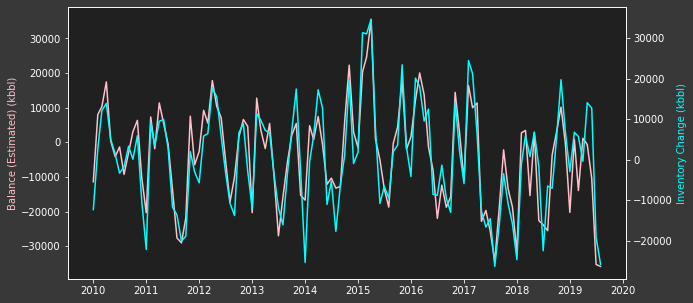

In [0]:
#@title Chart data
LeftAxis = "Balance (Estimated)" #@param ["",'Production','Imports','Exports','Net Imports','Refinery Input','Inventories (w/ SPR)','Inventory Change','Balance (Estimated)','WTI','Brent','Rigs']
RightAxis = "Inventory Change" #@param ["",'Production','Imports','Exports','Net Imports','Refinery Input','Inventories (w/ SPR)','Inventory Change','Balance (Estimated)','WTI','Brent','Rigs']
Start = '2010-01-01' #@param {type:"date"}
ChartSize = "Large" #@param ['Small','Medium','Large']
sizes = {'Small':2,'Medium':2.5,'Large':5}
ChartSize = sizes[ChartSize]

view = balance[balance.index >= Start]
units = dict(zip(["",'Production','Imports','Exports','Net Imports','Refinery Input','Inventories (w/ SPR)','Inventory Change','Balance (Estimated)','WTI','Brent','Rigs'],
        ["",' (kbbl)',' (kbbl)',' (kbbl)',' (kbbl)',' (kbbl)',' (kbbl)',' (kbbl)',' (kbbl)',' USD',' USD',' # of rigs']))

l_units = units[LeftAxis]
r_units = units[RightAxis]

fig, ax = plt.subplots(1)
fig.set_figheight(ChartSize)
fig.set_figwidth(ChartSize*2)

if LeftAxis != "":
    fig.patch.set_facecolor('#383838')
    ax.plot(view[LeftAxis], color = 'pink')
    ax.patch.set_facecolor('#202020')
    ax.set_ylabel(LeftAxis+l_units, color='pink')
    
if RightAxis != "":
    ax2 = ax.twinx()
    ax2.plot(view[RightAxis], color = 'cyan')
    ax2.set_ylabel(RightAxis+r_units, color='cyan')


#ax.set_title(f"Y: {LeftAxis} \n X: {RightAxis}")

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


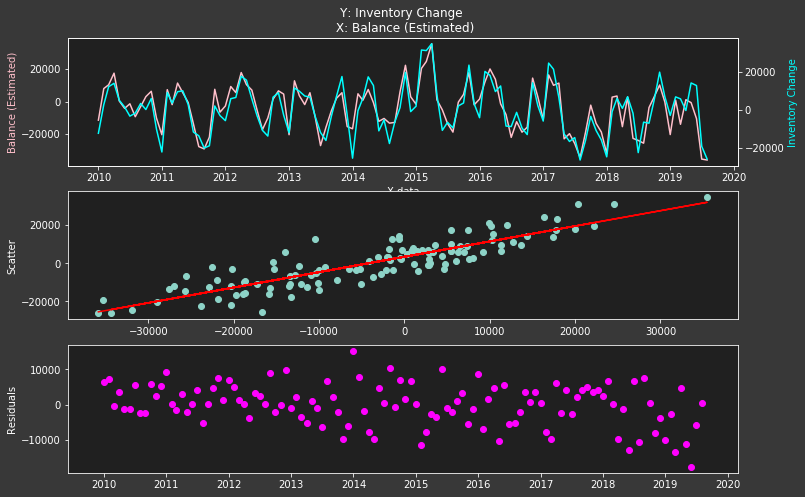

                            OLS Regression Results                            
Dep. Variable:       Inventory Change   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     407.3
Date:                Fri, 15 Nov 2019   Prob (F-statistic):           1.97e-39
Time:                        11:06:50   Log-Likelihood:                -1173.3
No. Observations:                 116   AIC:                             2351.
Df Residuals:                     114   BIC:                             2356.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3380.2095    

In [0]:
#@title Run a linear regression
X = "Balance (Estimated)" #@param ['Production','Imports','Exports','Net Imports','Refinery Input','Inventories (w/ SPR)','Inventory Change','Balance (Estimated)','WTI','Brent','Rigs']
Y = "Inventory Change" #@param ['Production','Imports','Exports','Net Imports','Refinery Input','Inventories (w/ SPR)','Inventory Change','Balance (Estimated)','WTI','Brent','Rigs']
Start = '2010-01-01' #@param {type:"date"}
ChartSize = "Large" #@param ['Small','Medium','Large']

calibrate(balance[balance.index >= Start],X,Y,ChartSize)